# Random Forest Classification of Depression and Gender by Vocal Characteristics
In this project, we will train a Random Forest Classifier to determine whether a participant has depression based on speech data from a clinical interview. The dataset contains 107 participants, 63 of which are male and 44 of which are female. Of these participants, 30 have depression (17 female, 14 male). By varying the weights and features included in the model training, we will demonstrate how differing analysis techniques can have significant impact on the model's classification performance. 

In [1]:
# **** MATH OPERATIONS ****
import numpy as np
import os

# **** DATA MANIPULATION ****
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from scipy import stats


In [25]:
# general functions
color_dict = {
    'all features': 'mediumpurple',
    'top performing features (depression)': 'darkviolet',
    'top perfoming features (gender)': 'plum',
    're-weighted features': 'indigo'
}
def load_features(path, labels_df):
    dataframes = []
    
    for file in os.listdir(path):
        if file.split('.')[1] != 'csv':
            continue
        df = pd.read_csv(os.path.join(path, file), header=None)
        participant_id = int(file.split("_")[1].split(".")[0]) # Get ID from file name
        df["Participant_ID"] = participant_id
        dataframes.append(df)
        
    # Combine into a single dataframe
    data_df = pd.concat(dataframes)
    return data_df.merge(labels_df, on="Participant_ID")

def pre_process(train_df, test_df):
    train_df.fillna(train_df.mean(), inplace=True)
    test_df.fillna(test_df.mean(), inplace=True)

    # Exclude the last 3 columns from normalization
    columns_to_normalize = train_df.columns[:-3]

    # Normalize the selected columns using Min-Max scaling
    scaler = StandardScaler()
    train_df_normalized = train_df.copy()
    train_df_normalized[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])

    # Remove outliers based on everything except the last 3 columns
    all_columns_except_last_3 = train_df.columns[:-3]
    z_scores = np.abs(stats.zscore(train_df_normalized[all_columns_except_last_3]))
    threshold = 1.5
    outlier_indices = np.where((z_scores < threshold).all(axis=1))[0]

    # Remove corresponding rows (including last 3 columns) when removing outliers
    train_df_no_outliers = train_df_normalized.drop(outlier_indices)
    test_df_normalized = test_df.copy()
    test_df_normalized[columns_to_normalize] = scaler.fit_transform(test_df[columns_to_normalize])
    return train_df_no_outliers, test_df_normalized

def analyze_results(test_df, prediction, display_results=True,  pred_label='Depression', threshold = 0.05):
    # Group by participant and average predictions 
    participant_predictions = test_df.groupby("Participant_ID")[prediction].mean()

    participant_predictions_binarized = (participant_predictions >= threshold).astype(int)

    # Join aggregated predictions back with the depression labels
    participant_labels = test_df.groupby("Participant_ID")[pred_label].first()

    # Filter data by gender
    male_participants = test_df[test_df["Gender"] == 1]["Participant_ID"].unique()
    female_participants = test_df[test_df["Gender"] == 0]["Participant_ID"].unique()

    # Calculate accuracies for all, male, and female participants
    all_metrics_depression = calculate_accuracy(participant_labels, 
                                                participant_predictions_binarized, "All participants",
                                                display_results=display_results)
 
    if pred_label == 'Depression':
        if display_results:
            print("")
        male_metrics = calculate_accuracy(participant_labels.loc[male_participants],
                                       participant_predictions_binarized.loc[male_participants], "Male participants",
                                       display_results=display_results)
        if display_results:
            print("")
        female_metrics = calculate_accuracy(participant_labels.loc[female_participants], 
                                        participant_predictions_binarized.loc[female_participants],
                                          "Female participants", display_results=display_results)

        # Calculate EO
        eo = (1 - abs(male_metrics["tpr"] - female_metrics["tpr"]))
        if display_results:
            print(f"Equality of Opportunity (EO): {eo:.2f}")

        return all_metrics_depression, male_metrics, female_metrics, eo
    return all_metrics_depression

def calculate_accuracy(y_true, y_pred, group, display_results=True):
    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate Balanced Accuracy
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    
    # Extract TP, FP, TN, FN
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    tpr = tp / (tp + fn) # True Positive Rate
    tnr = tn / (tn + fp) # True Negative Rate
    fpr = fp / (fp + tn) # False Positive Rate
    fnr = fn / (fn + tp) # False Negative Rate
    
    # Store metrics
    metrics = {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "tpr": tpr,
        "tnr": tnr,
        "fpr": fpr,
        "fnr": fnr
    }
    if display_results:
        print(f"Metrics for {group}:")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
        print(f"True Positive Rate (TPR): {tpr:.2f}")
        print(f"True Negative Rate (TNR): {tnr:.2f}")
        print(f"False Positive Rate (FPR): {fpr:.2f}")
        print(f"False Negative Rate (FNR): {fnr:.2f}")
    
    return metrics


def train_random_forest(X, y, group='All'):
    l = len(X)
    X_train = X[:int(0.7*l)]
    y_train = y[:int(0.7*l)]
    X_val = X[int(-0.3*l):]
    y_val = y[int(-0.3*l):]
    n_estimators = [10, 50, 100, 200]
    max_depth = [None, 10, 20, 50]
    best_acc = 0
    best_model = None
    best_param = None

    for n in n_estimators:
        for d in max_depth:
            clf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', n_estimators = n, max_depth = d)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            metric = calculate_accuracy(np.array(y_val), y_pred, group, display_results=False)
            if(metric['accuracy'] > best_acc):
                best_acc = metric['accuracy']
                best_model = clf
                best_param = n,d
    return best_acc, best_model, best_param

def manual_confusion_matrix(y_true, y_pred):
    # Initialize counts for true negatives (TN), false positives (FP), 
    # false negatives (FN), and true positives (TP)
    tn = fp = fn = tp = 0
    
    # Iterate over each pair of true and predicted labels
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == 0 and pred_label == 0:
            tn += 1
        elif true_label == 0 and pred_label == 1:
            fp += 1
        elif true_label == 1 and pred_label == 0:
            fn += 1
        elif true_label == 1 and pred_label == 1:
            tp += 1
    
    return tn, fp, fn, tp

def bar_graph(vals:dict, measures:list, title:str):
    x = np.arange(len(measures))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(12, 7))
    for attribute, measurement in vals.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=color_dict[attribute])
        ax.bar_label(rects, padding=5)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.set_xticks(x + width, measures)
    ax.legend(loc='upper left', ncols=4)
    ax.set_ylim(0, 1)
    fig.tight_layout()
    plt.show()

In [3]:
# pull in dataset & labels
labels_df = pd.read_csv("labels.csv")
train_df = load_features("features_train", labels_df)
test_df = load_features("features_test", labels_df)
train_df, test_df = pre_process(train_df, test_df)
# append feature names
features = pd.read_csv('feature_description.csv',
                    encoding = 'ISO-8859-1', 
                    names=['feature', 'description'])['feature'].values.tolist()
col_names = {x:features[x] for x in range(88)}
train_df.rename(columns=col_names, inplace=True)
test_df.rename(columns=col_names, inplace=True)

## Problem (1a) Classification of Gender and Depression
TODO Fill in

In [36]:
X_train = train_df.drop(["Participant_ID", "Depression", "Gender"], axis=1)
y_train_depression = train_df["Depression"]
y_train_gender= train_df["Gender"]


# Apply the same transformation to the test data
X_test = test_df.drop(["Participant_ID", "Depression", "Gender"], axis=1)
y_test_depression = test_df["Depression"]
y_test_gender = test_df["Gender"]

### Problem (a.i) Depression Classification
TODO Fill in


In [17]:
best_acc_depression, best_model_depression, best_param_depression = train_random_forest(X_train, y_train_depression)
print('Accuracy:', round(best_acc_depression, 2),' and best parameters: ',best_param_depression)
test_df['prediction_depression']= best_model_depression.predict(X_test)



Accuracy: 0.73  and best parameters:  (200, None)


In [ ]:
all_metrics_depression, male_metrics_depression, female_metrics_depression, eo = analyze_results(test_df, prediction='prediction_depression', pred_label='Depression', threshold=.2)

### Problem (a.ii) Gender Classification
TODO fill in

In [22]:
best_acc_gender, best_model_gender, best_param_gender = train_random_forest(X_train, y_train_gender)
print('Accuracy:', round(best_acc_gender, 2),' and best parameters: ', best_param_gender)
test_df['prediction_gender'] = best_model_gender.predict(X_test)


Accuracy: 0.89  and best parameters:  (100, 10)


In [26]:
x = 10
all_metrics_gender = analyze_results(test_df, prediction='prediction_gender', pred_label='Gender', threshold=.2)

Metrics for All participants:
Accuracy: 0.85
Balanced Accuracy: 0.81
True Positive Rate (TPR): 1.00
True Negative Rate (TNR): 0.62
False Positive Rate (FPR): 0.38
False Negative Rate (FNR): 0.00


## Problem (1b) Depression Feature Selection
In this section, we will repeat the same depression classification as above on only the features with the strongest correlation with depression.

In [27]:
# perform depression classification on the data
correlation_tups = []
for col in train_df.columns:
    if col in ['Participant_ID', 'Depression']:
        continue
    correlation_tups.append((col, train_df[col].corr(train_df['Depression'])))
correlation_tups = sorted(correlation_tups, key=lambda x: abs(x[1]), reverse=True)
top_twenty_feats = {correlation_tups[x][0]:round(correlation_tups[x][1], 3)  for x in range(20)}
print('Top twenty features correlated with depression: \n')
for key, val in top_twenty_feats.items():
    print(f'{key}: {val}')

Top twenty features correlated with depression: 

loudness_sma3_pctlrange0-2: 0.199
loudness_sma3_percentile80.0: 0.197
loudness_sma3_amean: 0.192
loudness_sma3_percentile50.0: 0.162
spectralFluxV_sma3nz_amean: 0.155
spectralFlux_sma3_amean: 0.137
loudness_sma3_meanRisingSlope: 0.136
loudness_sma3_meanFallingSlope: 0.124
HNRdBACF_sma3nz_amean: 0.116
F0semitoneFrom27.5Hz_sma3nz_percentile50.0: 0.115
loudness_sma3_stddevRisingSlope: 0.114
equivalentSoundLevel_dBp: 0.114
F0semitoneFrom27.5Hz_sma3nz_percentile20.0: 0.112
F0semitoneFrom27.5Hz_sma3nz_amean: 0.111
loudness_sma3_stddevFallingSlope: 0.109
F0semitoneFrom27.5Hz_sma3nz_percentile80.0: 0.109
loudness_sma3_percentile20.0: 0.099
spectralFluxV_sma3nz_stddevNorm: 0.097
Gender: -0.097
F1frequency_sma3nz_amean: 0.081


The participants with depression more frequently spoke loudly (loudness_sma3) and with more fluctuations (spectralFlux). There is also slight correlation between the vocal range (semitone) and the speaker's depression. Since the majority of participants with depression were female, there is a correlation between gender and depression, as well.

We will now train a Random Forest Classifier to predict depression using only the features most strongly correlated with depression. 

In [40]:
features = [correlation_tups[x][0] for x in range(5)]
filtered_df = X_train.loc[:, features]
filtered_test = X_test.loc[:, features]
filtered_test.head()

,loudness_sma3_pctlrange0-2,loudness_sma3_percentile80.0,loudness_sma3_amean,loudness_sma3_percentile50.0,spectralFluxV_sma3nz_amean
0,-0.675974,-0.725252,-0.697076,-0.384915,-0.519358
1,-0.401680,-0.182080,-0.101978,-0.073909,0.018555
2,-0.191265,-0.337158,-0.197889,-0.307052,-0.236540
3,-0.163767,-0.047027,0.039224,0.122366,-0.195008
4,-0.418077,-0.132925,0.031930,0.243504,-0.382822


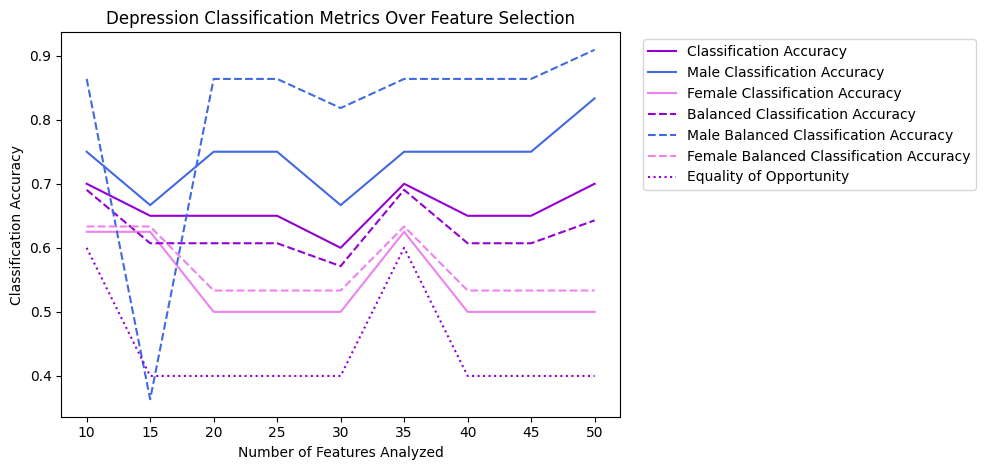

In [42]:
# add gender label back in
X_train_dep = X_train.copy()
X_train_dep['Gender'] = y_train_gender
X_test_dep = X_test.copy()
X_test_dep['Gender'] = y_test_gender
# run model on filtered features
class_acc_dep_fs, bca_dep_fs, male_class_acc_dep_fs, male_bca_dep_fs, female_class_acc_dep_fs, female_bca_dep_fs, eo_dep_fs = [],[],[],[],[], [], []
for n in range(10, 51, 5):
    # select top performing features
    features = [correlation_tups[x][0] for x in range(n)]
    filtered_df = X_train_dep.loc[:, features]
    # build random forest on these features
    best_acc, best_rand_forest, best_params = train_random_forest(filtered_df, y_train_depression)
    filtered_test = X_test_dep.loc[:, features]
    predictions = best_rand_forest.predict(filtered_test)
    # store accuracies
    test_df_pred = test_df.copy()
    test_df_pred['predictions'] = predictions
    all_res, male_res, female_res, eo_res = analyze_results(test_df_pred, prediction='predictions', 
                                                            threshold=.2,
                                                            display_results=False)
    class_acc_dep_fs.append(all_res['accuracy'])
    bca_dep_fs.append(all_res['balanced_accuracy'])
    male_class_acc_dep_fs.append(male_res['accuracy'])
    male_bca_dep_fs.append(male_res['balanced_accuracy'])
    female_class_acc_dep_fs.append(female_res['accuracy'])
    female_bca_dep_fs.append(female_res['balanced_accuracy'])
    eo_dep_fs.append(eo_res)


# plot results
fig, ax = plt.subplots(1, 1)
num_feats = range(10, 51, 5)
ax.plot(num_feats, class_acc_dep_fs, label = "Classification Accuracy", color='darkviolet') 
ax.plot(num_feats, male_class_acc_dep_fs, label = "Male Classification Accuracy", color='royalblue') 
ax.plot(num_feats, female_class_acc_dep_fs, label = "Female Classification Accuracy", color='violet') 
ax.plot(num_feats, bca_dep_fs, label = "Balanced Classification Accuracy", color='darkviolet', linestyle='dashed') 
ax.plot(num_feats, male_bca_dep_fs, label = "Male Balanced Classification Accuracy", color='royalblue', linestyle='dashed') 
ax.plot(num_feats, female_bca_dep_fs, label = "Female Balanced Classification Accuracy", color='violet', linestyle='dashed') 
ax.plot(num_feats, eo_dep_fs, label = "Equality of Opportunity", color='darkviolet', linestyle='dotted')
ax.set_title('Depression Classification Metrics Over Feature Selection')
ax.set_xlabel('Number of Features Analyzed')
ax.set_ylabel('Classification Accuracy')
fig.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 0.5, 0.5, 0.5)) 
plt.show()

The above plot shows the depression classification accuracy measures over male and female participants as the number of features included in the model increase. With minimal (10) features included in the model training, the Random Forest Classifier has its highest performance on female participants. As more features (with decreasing correlation) increase, the classification accuracy on male participants increases, while the classification accuracy on female participants decreases. 

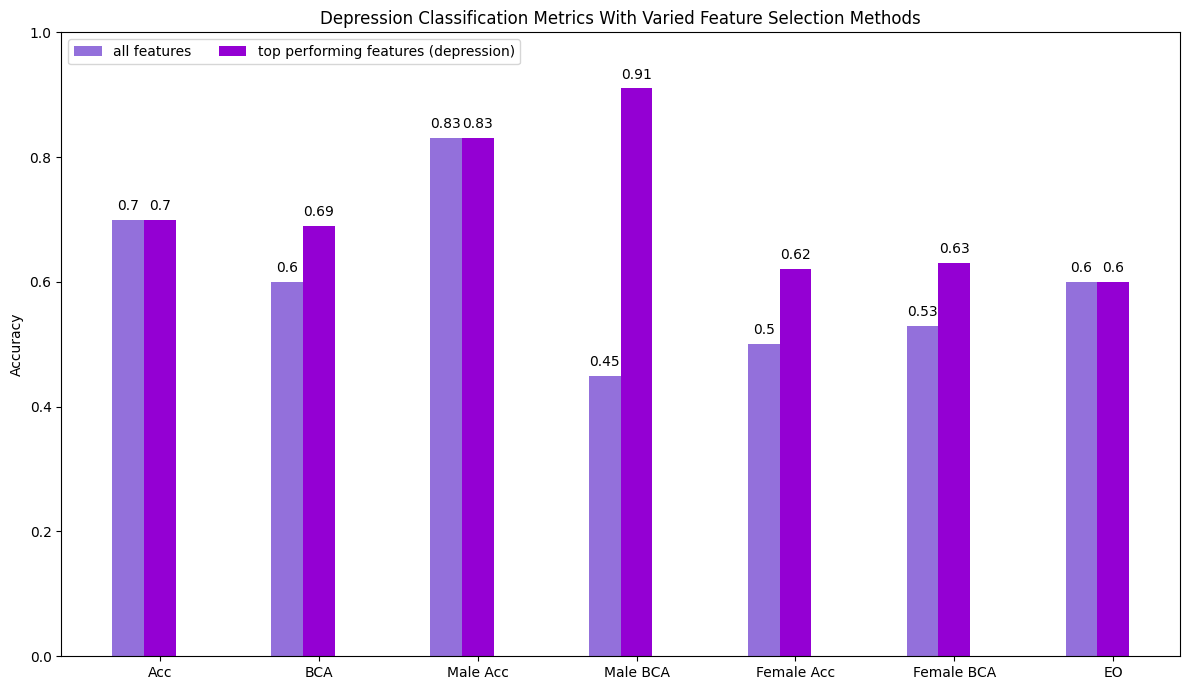

In [43]:
best_ind = bca_dep_fs.index(max(bca_dep_fs))
best_male_ind = male_bca_dep_fs.index(max(male_bca_dep_fs))
best_female_ind = female_bca_dep_fs.index(max(female_bca_dep_fs))
measures = ['Acc', 'BCA', 'Male Acc', 'Male BCA', 'Female Acc', 'Female BCA', 'EO']
all_metrics_depression = {x:round(y, 2) for x,y in all_metrics_depression.items()}
male_metrics = {x:round(y, 2) for x,y in male_metrics_depression.items()}
female_metrics = {x:round(y, 2) for x,y in female_metrics_depression.items()}
class_acc = [round(x, 2) for x in class_acc_dep_fs]
male_class_acc = [round(x, 2) for x in male_class_acc_dep_fs]
female_class_acc = [round(x, 2) for x in female_class_acc_dep_fs]
bca = [round(x, 2) for x in bca_dep_fs]
male_bca = [round(x, 2) for x in male_bca_dep_fs]
female_bca = [round(x, 2) for x in female_bca_dep_fs]
vals = {
    'all features': [all_metrics_depression['accuracy'], all_metrics_depression['balanced_accuracy'], 
                     male_metrics['accuracy'], male_metrics['balanced_accuracy'], 
                     female_metrics['accuracy'], female_metrics['balanced_accuracy'], .6],
    'top performing features (depression)': [class_acc[best_ind], bca[best_ind], 
                          male_class_acc[best_male_ind], male_bca[best_male_ind],
                          female_class_acc[best_female_ind], female_bca[best_female_ind], eo_dep_fs[best_ind]],     
}
bar_graph(vals, measures, 'Depression Classification Metrics With Varied Feature Selection Methods')

The balanced classification accuracy sees a slight change from the best performing feature-selection model to the original model. The overall classification accuracy remains unchanged. 
While the feature selection model increases accuracies for both male and female participants, there is a greater difference in the performance by gender than in the original model.
The original model performs better on classifying the female participants, with a 5% difference in the balanced classificaiton accuracy. However, the feature-selection model performs better on classifying male participants, with a 27% difference in the balanced classification accuracy. 

### Problem (1c) Gender Feature Selection
TODO Fill in

In [ ]:
# fill in

# line graph

### Problem (1d) Mitigating Bias Via Removing Gender-Dependent Features
TODO Fill in 

In [ ]:
# fill in

# bar graph comparing to part a

### Problem (1e) Mitigating Bias Via Other Approaches

#### Mitigating Bias via reweighting
Reweight the samples between female and male speakers by computing the proportion of two classes, and also by applying 'balanced' class weight for random forest classifier.

In [44]:
# sample based reweight

samples_per_gender = train_df['Gender'].value_counts()
total_samples = len(train_df)
inverse_representation = total_samples / samples_per_gender
print(samples_per_gender)

train_df_weights = train_df.copy()
train_df_weights['weights'] = train_df['Gender'].map(inverse_representation)
reweights = train_df_weights['weights']

Gender
1    6873
0    4889
Name: count, dtype: int64


In [45]:
model_sbr = RandomForestClassifier(random_state=42, class_weight='balanced')
model_sbr.fit(X_train, y_train_depression, sample_weight=reweights)

y_pred_sbr = model_sbr.predict(X_test)
all_sbr, male_sbr, female_sbr, eo_sbr = analyze_results(y_pred_sbr)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- prediction_depression
- prediction_gender


#### Mitigating bias via autoencoder
Implement autoencoder by training a multi-task neural network. Through the training, compute the loss for gender and depression, and try to decrease the loss of depression prediction while increasing the loss of gender prediction, which will make sure the output features will represent depression well but gender badly. To achieve that, use the negative value of binary cross entropy of gender prediction. After training, take the output as the transformed features.

In [ ]:
# auto-encoder 

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

input_layer = Input(shape=(88,))
encoded = Dense(44, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
decoded = Dense(88, activation='sigmoid', name='decoded')(encoded)

gender_output = Dense(1, activation='sigmoid', name='gender')(encoded)
depression_output = Dense(1, name='depression')(encoded)

autoencoder = Model(inputs=input_layer, outputs=[decoded, gender_output, depression_output])

def negative_binary_crossentropy(y_true, y_pred):
    return -tf.keras.losses.binary_crossentropy(y_true, y_pred)
def mean_squared_error(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)
losses = {
    'decoded': mean_squared_error,
    'gender': negative_binary_crossentropy,
    'depression': mean_squared_error,
}

autoencoder.compile(optimizer='adam', loss=losses)

autoencoder.fit(X_train, [X_train, y_train_gender, y_train_depression], epochs=10, batch_size=32)
X_train_encoded = autoencoder.predict(X_train)[0]

In [ ]:
model_aer = RandomForestClassifier(random_state=42, class_weight='balanced')
model_aer.fit(X_train_encoded, y_train_depression)

y_pred_aer = model_aer.predict(X_test)
all_aer, male_aer, female_aer, eo_aer = analyze_results(y_pred_aer)

In [ ]:
vals = {
    'all features': [all_metrics_depression['accuracy'], all_metrics_depression['balanced_accuracy'], 
                     male_metrics['accuracy'], male_metrics['balanced_accuracy'], 
                     female_metrics['accuracy'], female_metrics['balanced_accuracy'], .6],
    'SBR features': [all_sbr['accuracy'], all_sbr['balanced_accuracy'], 
                     male_sbr['accuracy'], male_sbr['balanced_accuracy'], 
                     female_sbr['accuracy'], female_sbr['balanced_accuracy'], eo_sbr],
    'AER features': [all_aer['accuracy'], all_aer['balanced_accuracy'], 
                 male_aer['accuracy'], male_aer['balanced_accuracy'], 
                 female_aer['accuracy'], female_aer['balanced_accuracy'], eo_aer]
}
bar_graph(vals, measures, 'Depression Classification Metrics With Debiasing')

According to the graph, mitigating bias will reduce the accuracy of the model. This might be because the model is trained on imbalanced value, so it can get high accuracy by simply predicting the class which has more samples. Balanced accuracy would be increased through this transformation. The accuracy on male class, which has more samples, will decrease as well. It makes sense because it takes a huge percentage of the overall accuracy. Moreover, the performance of using autoencoder will mostly depend on how well the autoencoder is trained, as in this task, where the autoencoder struggles with reducing losses stably, the final performance changes a lot.  
One interesting thing to notice is that after autoencoder, the EO could reach to 1, which indicates it a better choice of mitigating bias.